## Dev_MMD_Index

### Row Counts to Index Scores by Month, Day of week and Hour

##### [Ctrl + Enter] 0. Import Modules

In [144]:
# import modules
import requests
import sys
import os
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('classic')
import csv
from datetime import datetime as dt
from dateutil import parser

##### [Change Scripts] 1. Import File

In [145]:
# Import excel spreadsheet to data frame
# Change the data path as your spreadsheet location
mmd1_df = pd.read_excel(r'C:/ArcGIS/Projects/Dev_MMD/csv/AEO_UWS_ColumbusAve-MMDResults-20220627170015.xlsx', 'FT Historical Trends')
mmd2_df = pd.read_excel(r'C:/ArcGIS/Projects/Dev_MMD/csv/AEO_UWS_ColumbusCircle-MMDResults-20220627160037.xlsx', 'FT Historical Trends')
mmd1_df.dtypes
# Since Date column is object, which is character, it needs to be changed to datetime column

Date            object
Hour             int64
Count            int64
DateTime         int64
Project Name    object
Connected       object
FileName        object
dtype: object

##### [Ctrl + Enter] 2. Change to Datetime Column

In [146]:
# Change Date column ('character') to datetime column
mmd1_df['Date'] = pd.to_datetime(mmd1_df['Date'])
mmd2_df['Date'] = pd.to_datetime(mmd2_df['Date'])

##### [Change Scripts] 3.Set Time Period 

In [147]:
# Filtering the exact target datetime
# Please enter the exact time period for each MMD report
mmd1_df = mmd1_df[(mmd1_df['Date'] >= '2019-01-01') & (mmd1_df['Date'] <= '2019-12-31')]
mmd2_df = mmd2_df[(mmd2_df['Date'] >= '2019-01-01') & (mmd2_df['Date'] <= '2019-12-31')]
mmd1_df

,Date,Hour,Count,DateTime,Project Name,Connected,FileName
5,2019-01-01,0,32,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
6,2019-01-01,1,43,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
7,2019-01-01,2,32,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
8,2019-01-01,3,20,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
9,2019-01-01,4,15,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
...,...,...,...,...,...,...,...
8754,2019-12-31,14,41,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
8755,2019-12-31,15,41,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
8756,2019-12-31,16,39,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...
8757,2019-12-31,17,33,20220627170015,AEO_UWS_ColumbusAve,Yes,N:\Team-GISData\Distributed_Data\Alteryx\Modul...


##### [Ctrl+Enter] 4. Calculating Index Scores

In [148]:
# Create new columns of Year, Month, Day, and Day of Week from Datetime column
mmd1_df['Year'] = mmd1_df['Date'].dt.year
mmd1_df['Month'] = mmd1_df['Date'].dt.month
mmd1_df['Day'] = mmd1_df['Date'].dt.day
mmd1_df['Weekday'] = mmd1_df['Date'].dt.day_name()
mmd2_df['Year'] = mmd2_df['Date'].dt.year
mmd2_df['Month'] = mmd2_df['Date'].dt.month
mmd2_df['Day'] = mmd2_df['Date'].dt.day
mmd2_df['Weekday'] = mmd2_df['Date'].dt.day_name()

# Select columns and create summary dateframe
mmd1_summary_df = mmd1_df[["Date", "Year", "Month", "Day", "Weekday", "Hour", "Count"]]
mmd2_summary_df = mmd2_df[["Date", "Year", "Month", "Day", "Weekday", "Hour", "Count"]]



# Sum count group by month and create a combined dataframe with MMD
mmd1_month_df = mmd1_summary_df.groupby(by="Month", dropna=False).sum().reset_index()
mmd1_month_df['MMD'] = 'MMD_1'
mmd2_month_df = mmd2_summary_df.groupby(by="Month", dropna=False).sum().reset_index()
mmd2_month_df['MMD'] = 'MMD_2'
mmd_month_df = mmd1_month_df.append(mmd2_month_df)

# Sum count group by weekday and create a combined dataframe with MMD
mmd1_weekday_df = mmd1_summary_df.groupby(by="Weekday", dropna=False).sum()[["Count"]]
mmd1_weekday_df['MMD'] = 'MMD_1'
mmd2_weekday_df = mmd2_summary_df.groupby(by="Weekday", dropna=False).sum()[["Count"]]
mmd2_weekday_df['MMD'] = 'MMD_2'
# Re-order the rows by weekday orders (Monday to Sunday)
lst_weekday = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
mmd1_weekday_df = mmd1_weekday_df.loc[lst_weekday]
mmd2_weekday_df = mmd2_weekday_df.loc[lst_weekday]
mmd_weekday_df = mmd1_weekday_df.append(mmd2_weekday_df)
# Reset Index 
mmd_weekday_df = mmd_weekday_df.reset_index()

# Sum count group by Hour and create a combined dataframe with MMD
mmd1_hour_df = mmd1_summary_df.groupby(by="Hour", dropna=False).sum().reset_index()
mmd1_hour_df['MMD'] = 'MMD_1'
mmd2_hour_df = mmd2_summary_df.groupby(by="Hour", dropna=False).sum().reset_index()
mmd2_hour_df['MMD'] = 'MMD_2'
mmd_hour_df = mmd1_hour_df.append(mmd2_hour_df)



# Create columns for calculating index
# 1) Mean of Counts
mmd_month_df["Mean_Month"] = mmd_month_df["Count"].mean()
mmd_weekday_df["Mean_Weekday"] = mmd_weekday_df["Count"].mean()
mmd_hour_df["Mean_Hour"] = mmd_hour_df["Count"].mean()

# 2) Standard Deviation of Counts
mmd_month_df["Stdv_Month"] = mmd_month_df["Count"].std()
mmd_weekday_df["Stdv_Weekday"] = mmd_weekday_df["Count"].std()
mmd_hour_df["Stdv_Hour"] = mmd_hour_df["Count"].std()

# 3) Varaibles Weights
mmd_month_df["Var1_Weight"] = 1
mmd_weekday_df["Var1_Weight"] = 1
mmd_hour_df["Var1_Weight"] = 1

# 4) Z-score
mmd_month_df["Var1_Z"] = (mmd_month_df["Count"] - mmd_month_df["Mean_Month"]) / mmd_month_df["Stdv_Month"]
mmd_weekday_df["Var1_Z"] = (mmd_weekday_df["Count"] - mmd_weekday_df["Mean_Weekday"]) / mmd_weekday_df["Stdv_Weekday"]
mmd_hour_df["Var1_Z"] = (mmd_hour_df["Count"] - mmd_hour_df["Mean_Hour"]) / mmd_hour_df["Stdv_Hour"]

# 5) Capped Z-Score
mmd_month_df["Var1_CappedZ"] = np.where(mmd_month_df["Var1_Z"] > 3, 3,
                                        np.where(mmd_month_df["Var1_Z"] < -3, -3, mmd_month_df["Var1_Z"])
                                       )
mmd_weekday_df["Var1_CappedZ"] = np.where(mmd_weekday_df["Var1_Z"] > 3, 3,
                                          np.where(mmd_weekday_df["Var1_Z"] < -3, -3, mmd_weekday_df["Var1_Z"])
                                       )
mmd_hour_df["Var1_CappedZ"] = np.where(mmd_hour_df["Var1_Z"] > 3, 3,
                                       np.where(mmd_hour_df["Var1_Z"] < -3, -3, mmd_hour_df["Var1_Z"])
                                       )

# 6) Combined Z-Score
mmd_month_df["Com_Z"] = mmd_month_df["Var1_Weight"] * mmd_month_df["Var1_CappedZ"]
mmd_weekday_df["Com_Z"] = mmd_weekday_df["Var1_Weight"] * mmd_weekday_df["Var1_CappedZ"]
mmd_hour_df["Com_Z"] = mmd_hour_df["Var1_Weight"] * mmd_hour_df["Var1_CappedZ"]

# 7) Max Z-Score
mmd_month_df["Max_Z"] = mmd_month_df["Com_Z"].max()
mmd_weekday_df["Max_Z"] = mmd_weekday_df["Com_Z"].max()
mmd_hour_df["Max_Z"] = mmd_hour_df["Com_Z"].max()

# 8) Demand Index
mmd_month_df["Demand_Index"] = (1 + (mmd_month_df["Com_Z"]/mmd_month_df["Max_Z"])) * 100
mmd_weekday_df["Demand_Index"] = (1 + (mmd_weekday_df["Com_Z"]/mmd_weekday_df["Max_Z"])) * 100
mmd_hour_df["Demand_Index"] = (1 + (mmd_hour_df["Com_Z"]/mmd_hour_df["Max_Z"])) * 100

# 9) Mean of Demand Index
mmd_month_df["Mean_DemandIndex"] = mmd_month_df["Demand_Index"].mean()
mmd_weekday_df["Mean_DemandIndex"] = mmd_weekday_df["Demand_Index"].mean()
mmd_hour_df["Mean_DemandIndex"] = mmd_hour_df["Demand_Index"].mean()

# 10) Pre Final Score
mmd_month_df["Pre_FinalScore"] = mmd_month_df["Demand_Index"] / mmd_month_df["Mean_DemandIndex"] * 100
mmd_weekday_df["Pre_FinalScore"] = mmd_weekday_df["Demand_Index"] / mmd_weekday_df["Mean_DemandIndex"] * 100
mmd_hour_df["Pre_FinalScore"] = mmd_hour_df["Demand_Index"] / mmd_hour_df["Mean_DemandIndex"] * 100

# 11) Final Score
mmd_month_df["Final_Score"] = np.where(mmd_month_df["Pre_FinalScore"] < 0, 0, 
                                      mmd_month_df["Pre_FinalScore"])
mmd_weekday_df["Final_Score"] = np.where(mmd_weekday_df["Pre_FinalScore"] < 0, 0, 
                                         mmd_weekday_df["Pre_FinalScore"])
mmd_hour_df["Final_Score"] = np.where(mmd_hour_df["Pre_FinalScore"] < 0, 0, 
                                      mmd_hour_df["Pre_FinalScore"])

# 12) Select Columns 
mmd_month_final_df = mmd_month_df[["Month", "Final_Score", "MMD"]]
mmd_weekday_final_df = mmd_weekday_df[["Weekday", "Final_Score", "MMD"]]
mmd_hour_final_df = mmd_hour_df[["Hour", "Final_Score", "MMD"]]

In [149]:
# Index Score by Months
mmd_month_final_df  

,Month,Final_Score,MMD
0,1,109.731875,MMD_1
1,2,83.013493,MMD_1
2,3,87.176728,MMD_1
3,4,87.493625,MMD_1
4,5,93.946441,MMD_1
5,6,87.164844,MMD_1
6,7,69.917722,MMD_1
7,8,61.714050,MMD_1
8,9,72.369713,MMD_1
9,10,59.749288,MMD_1


In [150]:
# Index Score by Day of Week
mmd_weekday_final_df  

,Weekday,Final_Score,MMD
0,Monday,26.969324,MMD_1
1,Tuesday,41.488500,MMD_1
2,Wednesday,44.247204,MMD_1
3,Thursday,40.534949,MMD_1
4,Friday,48.469219,MMD_1
5,Saturday,31.227323,MMD_1
6,Sunday,17.793637,MMD_1
7,Monday,158.943297,MMD_2
8,Tuesday,188.713305,MMD_2
9,Wednesday,197.739063,MMD_2


In [151]:
# Index Score by Hour
mmd_hour_final_df  

,Hour,Final_Score,MMD
0,0,35.180705,MMD_1
1,1,25.456144,MMD_1
2,2,22.818379,MMD_1
3,3,23.404549,MMD_1
4,4,26.007144,MMD_1
5,5,34.055259,MMD_1
6,6,51.347275,MMD_1
7,7,77.830438,MMD_1
8,8,101.464815,MMD_1
9,9,106.500015,MMD_1


##### [Ctrl+Enter] 5. Create Save Plots

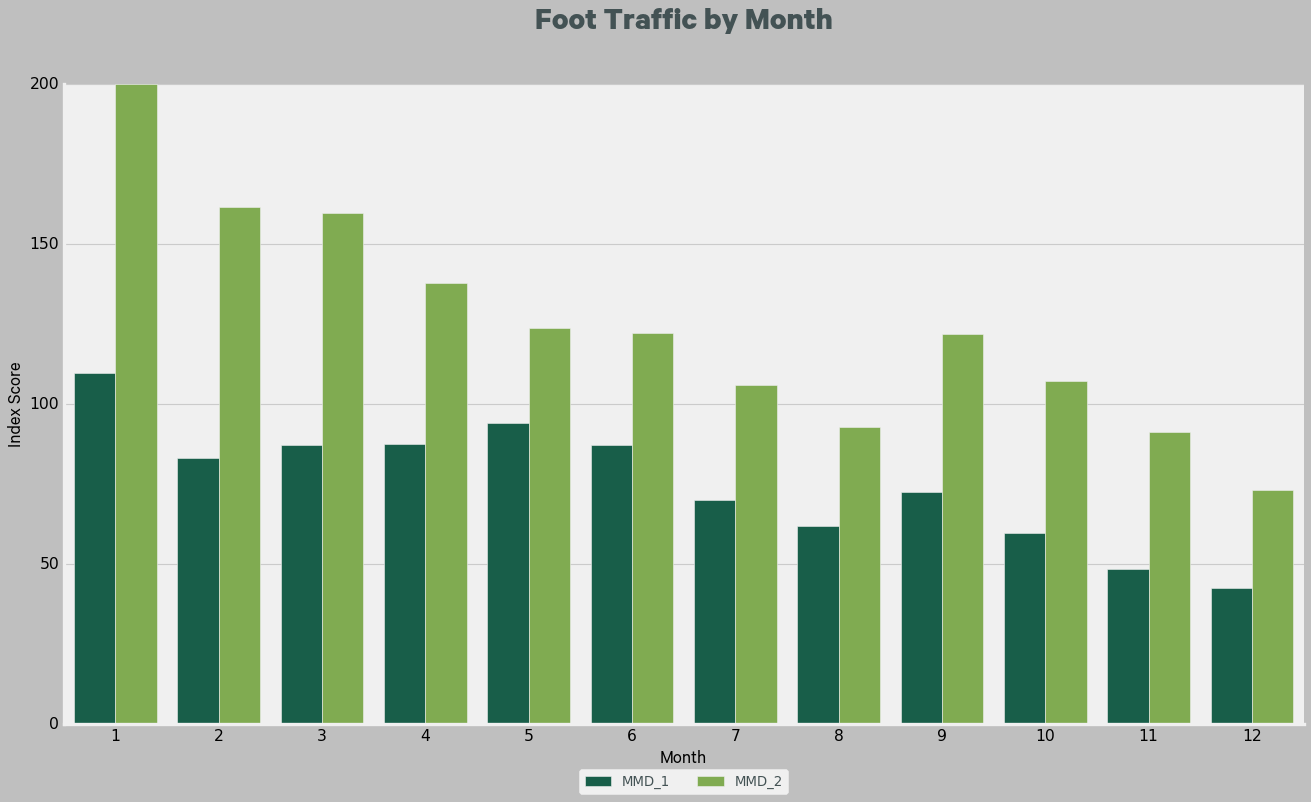

In [152]:
# Set the figure size
plt.figure(figsize=(20, 10))
plt.style.use('fivethirtyeight')

# Create an array with the colors you want to use

colors = ["#0C6A4D", "#80BA42"]
sns.set_palette(sns.color_palette(colors))

# grouped barplot
ax = sns.barplot(
    x="Month", 
    y="Final_Score", 
    hue="MMD", 
    data=mmd_month_final_df
    )

# Customize the axes and title
cfont_title = {'family': 'Calibre',
               'weight': 'bold',
               'size': 30,
               'color':'#435254'
              }
cfont = {'family': 'Calibre',
         'size': 17
        }
ax.set_title("Foot Traffic by Month", **cfont_title, pad = 50)
ax.set_ylabel("Index Score", **cfont)
ax.set_xlabel("Month", **cfont)
leg = ax.legend(bbox_to_anchor=(0.5, -0.12), loc = 'lower center', ncol = 2, prop = {'size': 12})
for text in leg.get_texts():
    text.set_color("#435254")

# Remove top and right borders
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

##### [Ctrl+Enter] 5. Create Save Plots

In [153]:
plt.savefig(r"C:/ArcGIS/Projects/Dev_MMD/csv/1_FootTraffic_Month.png")